<a href="https://colab.research.google.com/github/VJsai45/IIT-Madras-IPL-Score-Predcition-Hackathon/blob/main/IIT_Madras_IPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IPL Linear Regression


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt


In [ ]:
# Read all ipl matches data from csv
allDataDF = pd.read_csv('/content/drive/MyDrive/Deep Learning Data/IIT Madras IPL Data/all_matches_new.csv');
allDataDF.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,bowler,runs_off_bat,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
0,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,0.1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,P Kumar,0,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,0.2,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,0.3,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,0.4,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,335982,2007/08,2008-04-18,M Chinnaswamy Stadium,1,0.5,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# convert the match dates from string to pandas datetime format
allDataDF.start_date = pd.to_datetime(allDataDF.start_date)

In [ ]:
# To view all rows data
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
  allDataDF[(allDataDF.start_date > '2015-01-01') & (allDataDF.match_id ==  829733) & (allDataDF.ball < 6.0) & (allDataDF.innings == 1)]

In [ ]:
# Filter last 3 years' data for first six overs and group by matchid and innings to get the runs scored also.
sixOversData = allDataDF[(allDataDF.start_date > '2021-01-01')  & (allDataDF.ball < 6.0) & (allDataDF.innings < 3)].groupby(by=['match_id','innings'],as_index=False).agg(
    {
        'venue': 'first',
        'batting_team':'first',
        'bowling_team':'first',
        'striker':lambda x : ','.join(x.unique()),
        'bowler':lambda x : ','.join(x.unique()),
        'runs_off_bat':'sum',
        'extras':'sum'
    }
)
sixOversData['runs'] = sixOversData.runs_off_bat + sixOversData.extras
sixOversData.drop('runs_off_bat',axis=1,inplace=True)
sixOversData.drop('extras',axis=1,inplace=True)
sixOversData.drop('match_id',axis=1,inplace=True)


In [ ]:
# stadium dictionary to map and update spelling mistakes to the correct names
stadiumDictionary = {'Arun Jaitley Stadium': 'Arun Jaitley Stadium',
 'Brabourne Stadium': 'Brabourne Stadium',
 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium': 'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium',
 'Dubai International Cricket Stadium': 'Dubai International Cricket Stadium',
 'Eden Gardens': 'Eden Gardens',
 'Feroz Shah Kotla': 'Arun Jaitley Stadium',
 'Green Park': 'Green Park',
 'Narendra Modi Stadium, Ahmedabad':'Narendra Modi Stadium',
 'Narendra Modi Stadium':'Narendra Modi Stadium',
 'Holkar Cricket Stadium': 'Holkar Cricket Stadium',
 'JSCA International Stadium Complex': 'JSCA International Stadium Complex',
 'M Chinnaswamy Stadium': 'M Chinnaswamy Stadium',
 'M.Chinnaswamy Stadium': 'M Chinnaswamy Stadium',
 'MA Chidambaram Stadium': 'MA Chidambaram Stadium',
 'MA Chidambaram Stadium, Chepauk': 'MA Chidambaram Stadium',
 'MA Chidambaram Stadium, Chepauk, Chennai': 'MA Chidambaram Stadium',
 'Maharashtra Cricket Association Stadium': 'Maharashtra Cricket Association Stadium',
 'Punjab Cricket Association IS Bindra Stadium': 'Punjab Cricket Association IS Bindra Stadium',
 'Punjab Cricket Association IS Bindra Stadium, Mohali': 'Punjab Cricket Association IS Bindra Stadium',
 'Punjab Cricket Association Stadium, Mohali': 'Punjab Cricket Association IS Bindra Stadium',
 'Rajiv Gandhi International Stadium': 'Rajiv Gandhi International Stadium',
 'Rajiv Gandhi International Stadium, Uppal': 'Rajiv Gandhi International Stadium',
 'Sardar Patel Stadium, Motera': 'Narendra Modi Stadium, Ahmedabad',
 'Saurashtra Cricket Association Stadium': 'Saurashtra Cricket Association Stadium',
 'Sawai Mansingh Stadium': 'Sawai Mansingh Stadium',
 'Shaheed Veer Narayan Singh International Stadium': 'Shaheed Veer Narayan Singh International Stadium',
 'Sharjah Cricket Stadium': 'Sharjah Cricket Stadium',
 'Sheikh Zayed Stadium': 'Sheikh Zayed Stadium',
 'Wankhede Stadium': 'Wankhede Stadium',
 'Wankhede Stadium, Mumbai': 'Wankhede Stadium'}

In [ ]:
# To map the stadium names
sixOversData.venue = sixOversData.venue.apply(lambda x : stadiumDictionary.get(x))

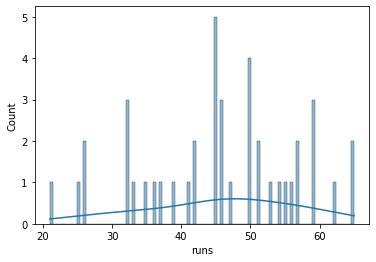

In [ ]:
# To check the distribution of runs
X = sixOversData.iloc[:,:-1]
y = sixOversData.iloc[:,6]
X,y
sns.histplot(data=sixOversData,x='runs',bins=100,kde=True)


In [ ]:
# Calculate IQR
def getIQRMean(inputData):
  return np.mean(inputData[inputData.between(inputData.quantile(.1), inputData.quantile(0.9), inclusive=True)])

In [ ]:
# Dataframe for batsmen strike rates
playerStrikeRates = allDataDF[(allDataDF.start_date > '2021-01-01')  & (allDataDF.ball < 6.0) & (allDataDF.innings < 3)].groupby(['striker'],as_index=False).agg(
    {
        'runs_off_bat':'mean'
    }
)
playerStrikeRates[playerStrikeRates["striker"].str.endswith("Ali")]
batsmenAveragesDict = playerStrikeRates.set_index('striker').T.to_dict('item')
batsmenAveragesDict['runs_off_bat']

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


{'AD Russell': 3.5,
 'AM Rahane': 0.8888888888888888,
 'BA Stokes': 0.0,
 'CA Lynn': 0.9285714285714286,
 'CH Gayle': 0.96875,
 'D Padikkal': 1.375,
 'DA Miller': 0.6153846153846154,
 'DA Warner': 1.1746031746031746,
 'DJ Hooda': 0.7142857142857143,
 'EJG Morgan': 1.2777777777777777,
 'F du Plessis': 1.4444444444444444,
 'GJ Maxwell': 1.7894736842105263,
 'Ishan Kishan': 0.3333333333333333,
 'JC Buttler': 1.24,
 'JM Bairstow': 1.710144927536232,
 'KL Rahul': 0.9782608695652174,
 'KS Williamson': 1.2222222222222223,
 'M Shahrukh Khan': 0.0,
 'M Vohra': 1.05,
 'MA Agarwal': 1.2469135802469136,
 'MK Pandey': 0.896551724137931,
 'MM Ali': 0.9166666666666666,
 'MP Stoinis': 0.0,
 'N Pooran': 0.0,
 'N Rana': 1.0465116279069768,
 'PP Shaw': 1.7058823529411764,
 'Q de Kock': 0.7931034482758621,
 'RA Tripathi': 1.1428571428571428,
 'RD Gaikwad': 0.8666666666666667,
 'RG Sharma': 1.2705882352941176,
 'RM Patidar': 0.8181818181818182,
 'RR Pant': 1.3636363636363635,
 'S Dhawan': 1.202702702702702

In [ ]:
# Dataframe for bowler economy rates
bowlerAverage = allDataDF[(allDataDF.start_date > '2021-01-01') & (allDataDF.ball < 6.0) & (allDataDF.innings < 3) ].groupby(['bowler'],as_index=False).agg(
    {
        'runs_off_bat':'mean',
        'extras':'mean'
    }
)
bowlerAverage['economy'] = (bowlerAverage.runs_off_bat + bowlerAverage.extras)*6
bowlerAverage.drop('runs_off_bat',axis=1,inplace=True);
bowlerAverage.drop('extras',axis=1,inplace=True);
bowlerAveragesDict = bowlerAverage.set_index('bowler').T.to_dict('item')
bowlerAveragesDict['economy']

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


{'A Mishra': 10.0,
 'AF Milne': 16.285714285714285,
 'AR Patel': 11.0,
 'Abhishek Sharma': 6.947368421052632,
 'Arshdeep Singh': 7.199999999999999,
 'Avesh Khan': 5.76,
 'B Kumar': 5.781818181818181,
 'C Sakariya': 6.352941176470589,
 'CH Morris': 7.2631578947368425,
 'CR Woakes': 5.428571428571429,
 'CV Varun': 7.783783783783782,
 'DJ Hooda': 2.5,
 'DL Chahar': 7.636363636363637,
 'FA Allen': 9.428571428571429,
 'Harbhajan Singh': 6.181818181818182,
 'J Suchith': 3.0,
 'J Yadav': 8.5,
 'JA Richardson': 9.84,
 'JD Unadkat': 6.625,
 'JJ Bumrah': 5.441860465116279,
 'JO Holder': 7.384615384615383,
 'Jalaj S Saxena': 10.0,
 'K Rabada': 7.6,
 'KA Jamieson': 8.035714285714286,
 'KH Pandya': 8.32258064516129,
 'KK Ahmed': 7.875,
 'KW Richardson': 8.571428571428571,
 'L Ngidi': 8.769230769230768,
 'LI Meriwala': 12.923076923076925,
 'M Jansen': 9.789473684210527,
 'M Prasidh Krishna': 6.0,
 'MC Henriques': 4.800000000000001,
 'MP Stoinis': 8.333333333333332,
 'Mohammad Nabi': 5.0,
 'Mohammed 

In [ ]:
# Dataframe for batting team averages
battingTeam = sixOversData[['batting_team','runs']].groupby(by='batting_team',as_index=False).agg({'runs': lambda x: getIQRMean(x)})
battingTeam = battingTeam.rename(columns={'runs': 'batting_team_average'})
battingTeamDict = battingTeam.set_index('batting_team').T.to_dict('item')
battingTeamDict

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


{'batting_team_average': {'Chennai Super Kings': 43.333333333333336,
  'Delhi Capitals': 50.666666666666664,
  'Kolkata Knight Riders': 45.5,
  'Mumbai Indians': 45.333333333333336,
  'Punjab Kings': 40.0,
  'Rajasthan Royals': 42.333333333333336,
  'Royal Challengers Bangalore': 50.666666666666664,
  'Sunrisers Hyderabad': 52.0}}

In [ ]:
# Dataframe for bowling team averages
bowlingTeam = sixOversData[['bowling_team','runs']].groupby(by='bowling_team',as_index=False).agg({'runs': lambda x: getIQRMean(x)})
bowlingTeam = bowlingTeam.rename(columns={'runs': 'bowling_team_average'})
bowlingTeamDict = bowlingTeam.set_index('bowling_team').T.to_dict('item')
bowlingTeamDict

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


{'bowling_team_average': {'Chennai Super Kings': 55.0,
  'Delhi Capitals': 48.0,
  'Kolkata Knight Riders': 43.5,
  'Mumbai Indians': 45.333333333333336,
  'Punjab Kings': 45.75,
  'Rajasthan Royals': 42.666666666666664,
  'Royal Challengers Bangalore': 47.333333333333336,
  'Sunrisers Hyderabad': 49.333333333333336}}

In [ ]:
sixOversData

,innings,venue,batting_team,bowling_team,striker,bowler,runs
0,1,MA Chidambaram Stadium,Mumbai Indians,Royal Challengers Bangalore,"RG Sharma,CA Lynn,SA Yadav","Mohammed Siraj,KA Jamieson,YS Chahal",41
1,2,MA Chidambaram Stadium,Royal Challengers Bangalore,Mumbai Indians,"Washington Sundar,V Kohli,RM Patidar,GJ Maxwell","TA Boult,JJ Bumrah,M Jansen,KH Pandya",46
2,1,Wankhede Stadium,Chennai Super Kings,Delhi Capitals,"RD Gaikwad,F du Plessis,MM Ali,SK Raina","CR Woakes,Avesh Khan,R Ashwin,TK Curran",33
3,2,Wankhede Stadium,Delhi Capitals,Chennai Super Kings,"PP Shaw,S Dhawan","DL Chahar,SM Curran,SN Thakur",65
4,1,MA Chidambaram Stadium,Kolkata Knight Riders,Sunrisers Hyderabad,"N Rana,Shubman Gill","B Kumar,Sandeep Sharma,T Natarajan,Mohammad Nabi",50
5,2,MA Chidambaram Stadium,Sunrisers Hyderabad,Kolkata Knight Riders,"WP Saha,DA Warner,MK Pandey,JM Bairstow","Harbhajan Singh,M Prasidh Krishna,Shakib Al Ha...",35
6,1,Wankhede Stadium,Punjab Kings,Rajasthan Royals,"KL Rahul,MA Agarwal,CH Gayle","C Sakariya,Mustafizur Rahman,CH Morris",46
7,2,Wankhede Stadium,Rajasthan Royals,Punjab Kings,"BA Stokes,SV Samson,M Vohra,JC Buttler","Mohammed Shami,JA Richardson,Arshdeep Singh,RP...",59
8,1,MA Chidambaram Stadium,Mumbai Indians,Kolkata Knight Riders,"RG Sharma,Q de Kock,SA Yadav","Harbhajan Singh,CV Varun,Shakib Al Hasan,PJ Cu...",42
9,2,MA Chidambaram Stadium,Kolkata Knight Riders,Mumbai Indians,"N Rana,Shubman Gill","TA Boult,M Jansen,JJ Bumrah,KH Pandya",45


In [ ]:
# Dataframe for stadium averages
stadiumData = sixOversData[['venue','runs']].groupby(by='venue',as_index=False).agg({'runs': lambda x: getIQRMean(x)})
stadiumData = stadiumData.rename(columns={'runs': 'stadium_average'})
stadiumDataDict = stadiumData.set_index('venue').T.to_dict('item')


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


In [ ]:

stadiumData = stadiumData.fillna(39.5)
stadiumData

,venue,stadium_average
0,MA Chidambaram Stadium,46.875000
1,Narendra Modi Stadium,39.500000
2,Wankhede Stadium,44.764706


In [ ]:
# method to get batsmen averages
def getAllBatsmenAverage(batsmen):
  batsmenAvgs =[] 
  iqr = np.mean(playerStrikeRates['runs_off_bat'][playerStrikeRates['runs_off_bat'].between(playerStrikeRates['runs_off_bat'].quantile(.1), playerStrikeRates['runs_off_bat'].quantile(.9), inclusive=True)])

  for b in batsmen.split(','):
    if b in playerStrikeRates.striker.unique():
      batsmenAvgs.append(playerStrikeRates[playerStrikeRates.striker == b]['runs_off_bat'].item())
    else:
      batsmenAvgs.append(getIQRMean(playerStrikeRates['runs_off_bat']))
  return np.mean(batsmenAvgs)
  # [playerStrikeRates[playerStrikeRates.striker == b]['runs_off_bat'] for b in batsmen.split(',')]

In [ ]:
# method to get bowler averages
def getAllBowlersAverage(bowlers):
  bowlerAvgs =[] 
  iqr = np.mean(bowlerAverage['economy'][bowlerAverage['economy'].between(bowlerAverage['economy'].quantile(.1), bowlerAverage['economy'].quantile(.9), inclusive=True)])

  for b in bowlers.split(','):
    if b in bowlerAverage.bowler.unique():
      bowlerAvgs.append(bowlerAverage[bowlerAverage.bowler == b]['economy'].item())
    else:
      bowlerAvgs.append(getIQRMean(bowlerAverage['economy']))
  return np.mean(bowlerAvgs)
  #np.mean([bowlerAverage[bowlerAverage.bowler == b]['economy'] for b in bowlers.split(',')])

In [ ]:
# method to get batting team averages
def getBattingTeamAverage(team):
  return (battingTeam[battingTeam.batting_team == team]['batting_team_average'].item() )
  # return battingTeam[battingTeam.batting_team == team]['batting_team_average'] 
getBattingTeamAverage("Chennai Super Kings")

43.333333333333336

In [ ]:
# method to get bowling team averages
def getBowlingTeamAverage(team):
  return (bowlingTeam[bowlingTeam.bowling_team == team]['bowling_team_average'].item() )

In [ ]:
# method to get stadium averages
def getStadiumAverage(stadium):
  return (stadiumData[stadiumData.venue == stadium]["stadium_average"].item())

In [ ]:
# make a copy
sixOversDataBatBowl = sixOversData
sixOversDataBatBowl.venue.unique()

array(['MA Chidambaram Stadium', 'Wankhede Stadium',
       'Narendra Modi Stadium'], dtype=object)

#Create Columns


In [ ]:
sixOversDataBatBowl['batsmen_average'] = sixOversDataBatBowl['striker'].apply(getAllBatsmenAverage)

In [ ]:
sixOversDataBatBowl['bowler_economy'] = sixOversDataBatBowl['bowler'].apply(getAllBowlersAverage)

In [ ]:
sixOversDataBatBowl['batting_team_average'] = sixOversDataBatBowl['batting_team'].apply(getBattingTeamAverage)

In [ ]:
sixOversDataBatBowl['bowling_team_average'] = sixOversDataBatBowl['bowling_team'].apply(getBowlingTeamAverage)

In [ ]:
sixOversDataBatBowl['stadium_average'] = sixOversDataBatBowl['venue'].apply(getStadiumAverage)

In [ ]:
sixOversDataBatBowl['wickets_fallen'] = sixOversDataBatBowl['striker'].apply(lambda x : len(x.split(',')) - 2)

In [ ]:
sixOversDataBatBowl.drop(columns=["venue","striker","bowler","batting_team","bowling_team"],inplace=True)

In [ ]:
sixOversDataBatBowl['innings'] = sixOversDataBatBowl.innings -1

In [ ]:
# sixOversDataStadium.drop('venue',axis=1,inplace=True)
sixOversDataBatBowl.wickets_fallen.unique()

array([1, 2, 0, 3, 4])

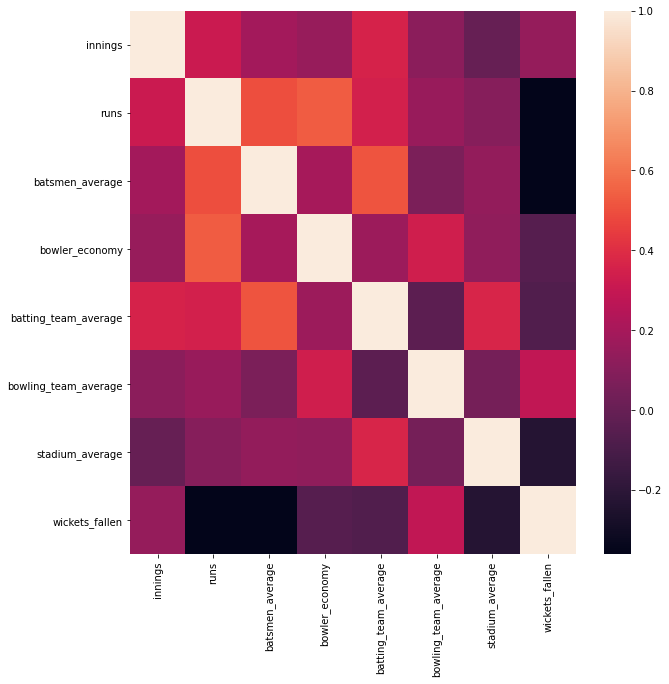

In [ ]:
 fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=sixOversDataBatBowl.corr(),ax=ax)


In [ ]:
sixOversDataBatBowl.drop('bowling_team_average',axis=1,inplace=True)
sixOversDataBatBowl

,innings,runs,batsmen_average,bowler_economy,batting_team_average,stadium_average,wickets_fallen
0,0,41,1.172078,7.315959,45.333333,46.875000,1
1,1,46,1.134820,7.627609,50.666667,46.875000,2
2,0,33,1.076175,5.655251,43.333333,44.764706,2
3,1,65,1.454293,8.623886,50.666667,44.764706,0
4,0,50,1.100179,8.445455,45.500000,46.875000,0
5,1,35,1.078658,7.255455,52.000000,46.875000,2
6,0,46,1.064641,6.696594,40.000000,44.764706,1
7,1,59,0.876848,9.215479,42.333333,44.764706,2
8,0,42,1.126922,7.701400,45.333333,46.875000,1
9,1,45,1.100179,7.627609,45.500000,46.875000,0


In [ ]:
sixOversDataBatBowl.to_csv('sixOversIpl.csv')

#Create Model

In [ ]:
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression,HuberRegressor,Ridge
from sklearn.model_selection import train_test_split

In [ ]:
X = sixOversDataBatBowl.drop('runs',axis=1)
y = sixOversDataBatBowl['runs']


In [ ]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# sc.fit(X)
# X = sc.transform(X)

In [ ]:
# theta = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),np.transpose(X)),y) 


In [ ]:
# theta

In [ ]:
# inputStandard = sc.transform(np.array([[ 1.        ,  1.06464148,  6.79812865, 40.        , 43.5       ,
#         39.5       ,  1.        ]]))
# inputStandard

In [ ]:
# X_mean = np.mean(X,axis=0)
# X_std = np.std(X,axis=0)
# X_mean,X_std

In [ ]:
# input = np.array([ 1.        ,  1.06464148,  6.79812865, 40.        , 43.5       ,
#         39.5       ,  1.        ])

In [ ]:
# inputSS = (input - X_mean)/(X_std)
# inputSS

In [ ]:
# np.dot(np.transpose(theta.reshape(7,1)), np.array(inputSS).reshape(7,1))

In [ ]:
# array([ 2.14954201,  0.95941477,  3.15385137,  0.6286454 ,  0.45900997,
#        -0.42459276, -2.83306946]) #non normalized

In [ ]:
reg2.coef_ #normalized

In [ ]:
# array([ 2.3654389 ,  2.27451274,  4.54332856,  1.28540892,  0.96805451,
#        -1.17927513, -3.70272905]) #normal equation

In [ ]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X = sc.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.10, random_state=42)

In [ ]:
X_train

In [ ]:
reg1 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True).fit(X_train, y_train)

In [ ]:
reg2 = BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None, compute_score=True,
               copy_X=True, fit_intercept=True, lambda_1=0.05, lambda_2=0.001,
               lambda_init=None, n_iter=300, normalize=False, tol=0.001,
               verbose=True).fit(X_train, y_train)
# reg3 = HuberRegressor(alpha=0.0005, epsilon=1.5, fit_intercept=True, max_iter=100,
#                 tol=1e-05, warm_start=False).fit(X_train, y_train)
# reg4 = Ridge(alpha=0.25, copy_X=True, fit_intercept=True, max_iter=None,
#        normalize=True, random_state=6306, solver='auto', tol=0.001).fit(X_train, y_train)

Convergence after  12  iterations


(103.09979297805569, -0.5126143335982352)

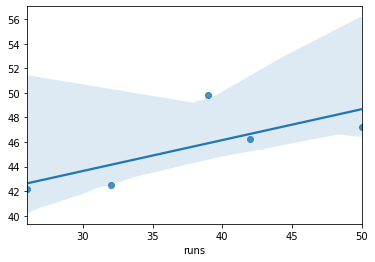

In [ ]:
y_pred = reg2.predict(X_test)
sns.regplot(x=y_test,y=y_pred)
from sklearn.metrics import mean_squared_error, r2_score

mean_squared_error(y_test, y_pred),r2_score(y_test, y_pred)

In [ ]:
sns.scatterplot(X_train[0],X_train[1],y_train)

In [ ]:
X_train

,innings,batsmen_average,bowler_economy,batting_team_average,stadium_average,wickets_fallen
39,1,1.026743,8.225153,52.000000,46.875000,2
19,1,1.114405,7.460653,45.500000,46.875000,1
29,1,1.436832,7.880296,45.500000,44.764706,4
30,0,0.974555,7.589768,42.333333,44.764706,3
6,0,1.064641,6.696594,40.000000,44.764706,1
27,1,1.442374,7.062622,52.000000,46.875000,0
12,0,1.032222,6.747033,50.666667,44.764706,3
17,1,1.442374,9.251669,52.000000,46.875000,0
9,1,1.100179,7.627609,45.500000,46.875000,0
15,1,1.075926,9.215479,43.333333,44.764706,1


In [ ]:
import plotly.express as px
df = X_train
fig = px.scatter_3d(x=X_train['batsmen_average'] ,y=X_train['bowler_economy'], z=X_train['wickets_fallen'],color=y_train)
fig.show()

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import Ridge

# # prepare a range of alpha values to test
# alphas = np.array([1,0.1,0.01,0.001,0.0001])
# params = {'alpha_1':[0.00001,0.0000001,0.01,0.001,0.0001],
#           'alpha_2':[0.00001,0.00000001,0.01,0.001,0.0001],
#           'lambda_1':[0.05,0.01,0.02,0.03,0.04],
#           'lambda_2':[0.1,0.001,0.002,0.003,0.004],
#           'tol':[0.004,0.001,0.002,0.003]}


# # create and fit a ridge regression model, testing each alpha
# model = BayesianRidge()
# grid = GridSearchCV(estimator=model, param_grid=params,verbose=True,n_jobs=-1,cv=10)
# grid.fit(X_train,y_train)
# grid

In [ ]:
# y_pred = pipe.predict(X_test)
# y_pred

In [ ]:
# from sklearn.svm import SVR
# reg_svr = SVR(kernel = 'poly',degree=3)
# reg_svr.fit(X_train,y_train)

In [ ]:
from sklearn.decomposition import PCA
p = PCA(n_components=3)
p.fit(X)
p.explained_variance_ratio_.sum()


0.9469432322796038

In [ ]:
principalComponents = p.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             )
principalDf

In [ ]:
X = principalDf

#Input Pipeline



In [ ]:
from sklearn.preprocessing import Normalizer
sc = StandardScaler()


In [ ]:
bowlerAverage[bowlerAverage['bowler'].str.contains("hman")]

,bowler,economy
36,Mujeeb Ur Rahman,13.000000
37,Mustafizur Rahman,6.473684


In [ ]:
ipl = np.array(['Wankhede Stadium',0,'Chennai Super Kings','Kolkata Knight Riders','F du Plessis,RD Gaikwad','CV Varun,SP Narine,M Prasidh Krishna'])

In [ ]:
ipl = np.array(['Wankhede Stadium',1,'Kolkata Knight Riders','Chennai Super Kings','N Rana,SP Narine,Shubman Gill,KD Karthik,EJG Morgan,RA Tripathi,ar','DL Chahar,SM Curran,L Ngidi'])

In [ ]:
ipl = np.array(['Wankhede Stadium',0,'Rajasthan Royals','Royal Challengers Bangalore','JC Buttler,M Vohra,DA Miller,SV Samson,S Dube','Mohammed Siraj,KA Jamieson,KW Richardson'])

In [ ]:
ipl = np.array(['MA Chidambaram Stadium',2,'Sunrisers Hyderabad','Delhi Capitals','DA Warner,JM Bairstow,KS Williamson','K Rabada,R Ashwin,MP Stoinis,AR Patel,Avesh Khan'])

In [ ]:
ipl = np.array(['MA Chidambaram Stadium',1,'Delhi Capitals','Sunrisers Hyderabad','PP Shaw,S Dhawan','Abhishek Sharma,KK Ahmed,S Kaul,J Suchith'])

In [ ]:
avg = getAllBatsmenAverage('JC Buttler,M Vohra,DA Miller,SV Samson')*4
avg = (avg + 1.4)/5
avg

1.1045551839464884

In [ ]:
def inputTransformer(iplInput):
  stadium_average = getStadiumAverage(iplInput[0])
  batsmen_average = getAllBatsmenAverage(iplInput[4])
  bowler_economy = getAllBowlersAverage(iplInput[5])
  batting_team_average = getBattingTeamAverage(iplInput[2])
  bowling_team_average = getBowlingTeamAverage(iplInput[3])
  wickets = len(iplInput[4].split(',')) - 2
  X = np.array([int(iplInput[1]),batsmen_average,bowler_economy,batting_team_average,bowling_team_average,stadium_average,wickets])
  # X = sc.fit_transform(X.reshape(1,-1))
  X = X.reshape(1,-1)
  return X

In [ ]:

X = inputTransformer(ipl)
X

array([[ 1.        ,  1.45429253,  6.37225877, 50.66666667, 49.33333333,
        46.875     ,  0.        ]])

In [ ]:
import joblib
  
# Save the model as a pickle in a file
joblib.dump(reg2, 'ipl_model_br_new.pkl')
  
# Load the model from the file
pklmodel = joblib.load('ipl_model_br_new.pkl') 
  
pklmodel


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None, compute_score=True,
              copy_X=True, fit_intercept=True, lambda_1=0.05, lambda_2=0.001,
              lambda_init=None, n_iter=300, normalize=False, tol=0.001,
              verbose=True)

In [ ]:
y_pred = reg2.predict(X)
y_pred